In [1]:
import pymc3 as pm
import numpy as np
from scipy.stats import ttest_ind

In [13]:
np.random.seed(0)
conversions1 = np.random.binomial(1, 0.01, size=5400)
conversions2 = np.random.binomial(1, 0.012, size=4600)

In [14]:
# observed conversion rates
print(f'Conversion Rate 1: {conversions1.mean():.1%}')
print(f'Conversion Rate 2: {conversions2.mean():.1%}')

Conversion Rate 1: 0.9%
Conversion Rate 2: 1.1%


In [15]:
print(f'P-Value: {ttest_ind(conversions1, conversions2, equal_var=False, alternative="less").pvalue:.1%}')

P-Value: 11.5%


In [16]:
# Bayesian method
with pm.Model():
  # priors
  rate1 = pm.Beta('rate1', 1, 99)
  rate2 = pm.Beta('rate2', 1, 99)

  # model
  obs1 = pm.Bernoulli('obs1', rate1, observed=conversions1)
  obs2 = pm.Bernoulli('obs2', rate2, observed=conversions2)

  # sample
  trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rate2, rate1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


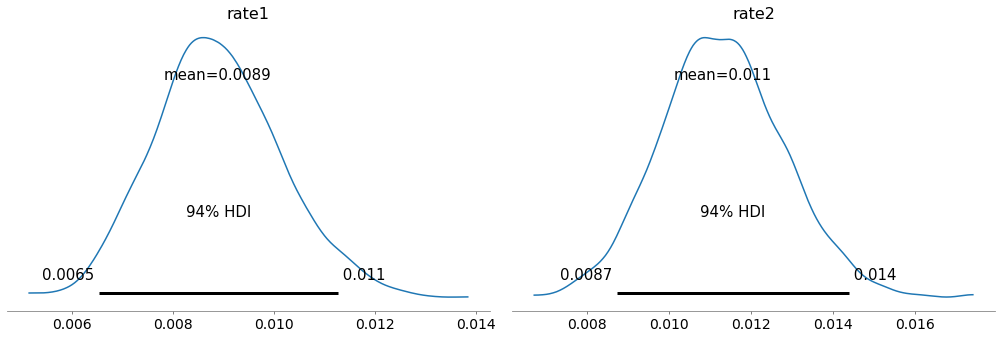

In [19]:
import arviz as az

az.plot_posterior(trace);

In [20]:
conversion1_samples = trace.posterior['rate1'].values
conversion2_samples = trace.posterior['rate2'].values

print(f'Probability that 2 is better than 1: {(conversion2_samples > conversion1_samples).mean():.1%}')

Probability that 2 is better than 1: 88.1%


# Real data time

In [21]:
import pandas as pd

In [26]:
data = pd.read_csv('Training_set_advance.csv')

In [32]:
# pretend everything else is randomized enough. We only want to test survival of urban vs. rural patients
use_data = data[['Patient_Rural_Urban', 'Survived_1_year']].copy()
use_data['urban'] = 0
use_data.loc[use_data['Patient_Rural_Urban']=='URBAN', 'urban'] = 1
use_data.head()

,Patient_Rural_Urban,Survived_1_year,urban
0,URBAN,1,1
1,RURAL,0,0
2,RURAL,1,0
3,RURAL,0,0
4,RURAL,1,0


In [34]:
urban = use_data.loc[use_data['urban'] == 1, 'Survived_1_year'].values
rural = use_data.loc[use_data['urban'] == 0, 'Survived_1_year'].values

In [36]:
# mean values
print(f'Urban Survival Rate: {np.mean(urban):.1%}')
print(f'Rural Survival Rate: {np.mean(rural):.1%}')

Urban Survival Rate: 54.7%
Rural Survival Rate: 67.2%


In [40]:
# traditional method
print(f'P-Value: {ttest_ind(urban, rural, equal_var=False).pvalue:.5%}')

P-Value: 0.00000%


In [41]:
# Bayesian method
with pm.Model():
  # prior
  urban_rate = pm.Beta('urban_rate', 5, 5)
  rural_rate = pm.Beta('rural_rate', 5, 5)

  # model
  urban_obs = pm.Bernoulli('urban_obs', urban_rate, observed=urban)
  rural_obs = pm.Bernoulli('rural_obs', rural_rate, observed=rural)

  # sample
  trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rural_rate, urban_rate]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


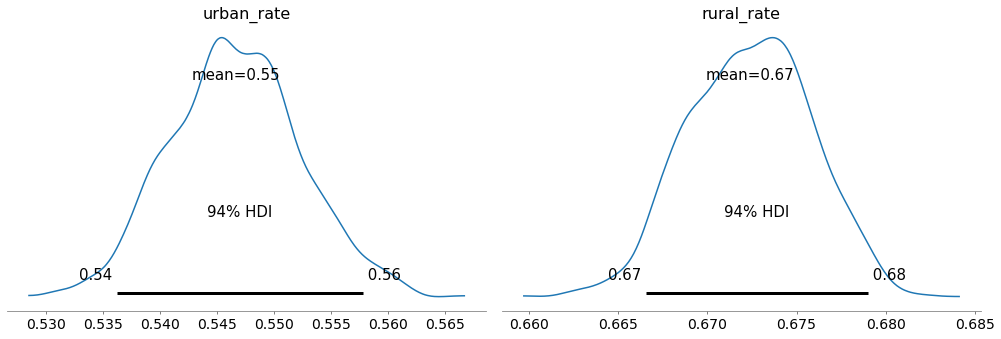

In [42]:
az.plot_posterior(trace);

In [45]:
urban_samples = trace.posterior['urban_rate'].values
rural_samples = trace.posterior['rural_rate'].values

print(f'Probability that Rural Patients survive at a higher rate than Urban Patients: {(rural_samples > urban_samples).mean():.5%}')

Probability that Rural Patients survive at a higher rate than Urban Patients: 100.00000%


## Attempt with Multiple Factors

We are going to use MCMC sampling (from PyMC3) for a linear regression. Yes, the dependent variable is binary and yes it makes sense to use logistic regression instead of linear...but we are going to do linear first.

In [72]:
mult_data = data[['Patient_Smoker', 'Patient_Rural_Urban', 'Survived_1_year']].copy()
mult_data['smoker'] = [0 if i == 'NO' else 1 for i in mult_data['Patient_Smoker'] ]
mult_data['urban'] = [0 if i == 'RURAL' else 1 for i in mult_data['Patient_Rural_Urban']]
smoker = mult_data['smoker'].values
urban = mult_data['urban'].values
survived = mult_data['Survived_1_year'].values

with pm.Model():
  # priors
  alpha = pm.Normal('alpha', 0, 1)
  beta0 = pm.Normal('beta0', 0, 1)
  beta1 = pm.Normal('beta1', 0, 1)
  beta2 = pm.Normal('beta2', 0, 1)
  sigma = pm.HalfNormal("sigma", 1)


  # model
  mu = alpha + beta0*smoker + beta1*urban + beta2*smoker*urban
  y = pm.Normal("y", mu, sigma, observed=survived)

  # sample
  trace = pm.sample(return_inferencedata=True) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta2, beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


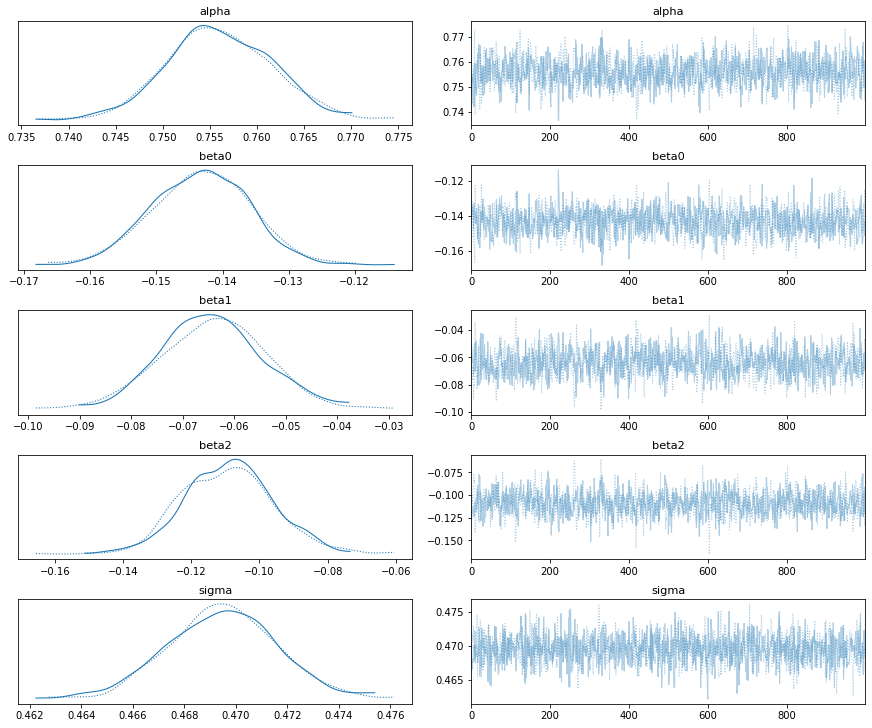

In [73]:
az.plot_trace(trace);

In [74]:
display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.76,0.01,0.75,0.77,0.0,0.0,1110.67,1268.39,1.0
beta0,-0.14,0.01,-0.16,-0.13,0.0,0.0,1181.23,1344.56,1.0
beta1,-0.06,0.01,-0.08,-0.04,0.0,0.0,1081.83,1280.94,1.0
beta2,-0.11,0.01,-0.13,-0.08,0.0,0.0,1139.62,1012.61,1.0
sigma,0.47,0.00,0.47,0.47,0.0,0.0,1702.53,1184.86,1.0


In [81]:
beta0_samples = trace.posterior['beta0'].values
beta1_samples = trace.posterior['beta1'].values
beta2_samples = trace.posterior['beta2'].values


print('Probability that each coefficient is positive:') 
print(f'Smoker: {(beta0_samples >= 0).mean():.5%}')
print(f'Urban: {(beta1_samples >= 0).mean():.5%}')
print(f'Interaction: {(beta2_samples >= 0).mean():.5%}')


Probability that each coefficient is positive:
Smoker: 0.00000%
Urban: 0.00000%
Interaction: 0.00000%


In [82]:
# traditional
import statsmodels.api as sm
from statsmodels.formula.api import ols

trad_lm = ols('Survived_1_year ~ smoker + urban + smoker*urban', data=mult_data).fit()
trad_anova = sm.stats.anova_lm(trad_lm)
trad_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Survived_1_year   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     436.7
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          1.35e-276
Time:                        03:10:25   Log-Likelihood:                -16624.
No. Observations:               25079   AIC:                         3.326e+04
Df Residuals:                   25075   BIC:                         3.329e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7559      0.006    137.379      0.000       0.745       0.767
smoker          -0.1431      0.007    -19.860      0.000      -0.157      -0.129
urban           -0.0641      0.010     -6.457      0.000      -0.084      -0.045
smoker:urban    -0.1092      0.013     -8.362      0.000      -0.135      -0.084
==============================================================================
Omnibus:                   151943.956   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3515.810
Skew:                          -0.527   Prob(JB):                         0.00
Kurtosis:                       1.499   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
trad_anova

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,187.762669,187.762669,851.623080,3.863355e-184
urban,1.0,85.687385,85.687385,388.646771,7.297213e-86
smoker:urban,1.0,15.415833,15.415833,69.920605,6.490793e-17
Residual,25075.0,5528.442139,0.220476,NaN,NaN


## Logistic Multiple Regression